 # データの読み込み

In [27]:
import pandas as pd
import numpy as np
import os
import pystan
from pystan.model import StanModel
import arviz as az

In [3]:
INPUT_DIR = r'C:\Users\Masat\デスクトップ_Instead\webアプリ開発\Tleague_scraping'
season_year = 2019
match_2018 = pd.read_csv(os.path.join(INPUT_DIR, f'{season_year}_match_result.csv'), header=0, encoding='utf-8')
display(match_2018.head())

,db,s1,s2,s3,vm,HomeTeam_name,AwayTeam_name,db_HomeWin,s1_HomeWin,s2_HomeWin,s3_HomeWin,vm_HomeWin,HomeTeam_win,HomeTeam_rate_AAA_and_S,AwayTeam_rate_AAA_and_S,HomeTeam_rate_S,AwayTeam_rate_S
0,12,30,31,23,10,木下マイスター東京,岡山リベッツ,0,1,1,0,1,1,0.555556,0.500000,0.444444,0.083333
1,12,32,31,13,1,日本生命レッドエルフ,木下アビエル神奈川,0,1,1,0,0,0,0.636364,0.500000,0.272727,0.200000
2,20,32,23,32,0,T.T彩たま,琉球アスティーダ,1,1,0,1,0,1,0.454545,0.500000,0.181818,0.100000
3,2,31,30,23,10,岡山リベッツ,T.T彩たま,0,1,1,0,1,1,0.500000,0.454545,0.083333,0.181818
4,21,31,13,30,0,木下アビエル神奈川,トップおとめピンポンズ名古屋,1,1,0,1,0,1,0.500000,0.416667,0.200000,0.166667


In [38]:
def load_matchData() -> pd.DataFrame:
    '''試合データをpd.DataFrameで読み込み'''
    datasets_list = []

    season_years = ["2019", "2020", "2021"]
    # 各シーズンのデータを読み込み
    for i, season_year in enumerate(season_years):
        datasets_list.append(pd.read_csv(
            f'{season_year}_match_result.csv', header=0, encoding='utf-8'))

        # シーズンカラムを付与する
        datasets_list[i]["season_year"] = int(season_year)

    # 縦に結合
    df_dataset = pd.concat(datasets_list)

    return df_dataset  # type: ignore


def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    '''
    観測データの前処理..
    '''

    def _get_unique_index(df: pd.DataFrame, target_column: str) -> pd.DataFrame:
        # まずユニーク値のリスト
        unique_list = df[target_column].unique()
        # indexとセットのdictを生成
        unique_index_dict = {team_name : (int(team_index) + 1)
                             for team_index, team_name  in enumerate(unique_list)}
        print(unique_index_dict)
        # mapメソッドで値を格納
        df[f'{target_column}_index'] = df[target_column].map(unique_index_dict)

        return df, unique_index_dict

    # 各レコード毎に、ホームチームのユニークなindexを作る.
    return _get_unique_index(df, target_column='HomeTeam_name')

def compile_stan_code(stan_filepath: str) -> StanModel:
    '''
    stanファイルをコンパイルし、StanModelインスタンスとしてReturnする関数.
    '''

    stan_model = StanModel(file=stan_filepath)

    return stan_model

def arrange_data_for_stan(df: pd.DataFrame, X1_column: str) -> dict:
    '''
    観測データを、StanModelに入力するデータ型に変換する関数.

    parameters
    -------------
    df:観測データ
    X1_column:観測データにおける、分析したい原因変数を指定。(ex. ダブルスの勝敗, シングルス1の勝敗, etc.)
    '''
    # DataFrame=>配列のdictに変換
    data = {'N': len(df), 'N_t': len(df['HomeTeam_name'].unique()), 'x1': df[X1_column],
            'x2': df['HomeTeam_rate_S'], 'x3': df['AwayTeam_rate_S'], 'y': df['HomeTeam_win'],
            't_id': df['HomeTeam_name_index']}
    return data

df = load_matchData()
df, unique_team_dict = preprocess(df)
print(df.head())
data = arrange_data_for_stan(df, X1_column='db_HomeWin')


{'木下マイスター東京': 1, '日本生命レッドエルフ': 2, 'T.T彩たま': 3, '岡山リベッツ': 4, '木下アビエル神奈川': 5, '日本ペイントマレッツ': 6, '琉球アスティーダ': 7, 'トップおとめピンポンズ名古屋': 8, '九州アスティーダ': 9}
   db  s1  s2  s3  vm HomeTeam_name   AwayTeam_name  db_HomeWin  s1_HomeWin  \
0  12  30  31  23  10     木下マイスター東京          岡山リベッツ           0           1   
1  12  32  31  13   1    日本生命レッドエルフ       木下アビエル神奈川           0           1   
2  20  32  23  32   0        T.T彩たま        琉球アスティーダ           1           1   
3   2  31  30  23  10        岡山リベッツ          T.T彩たま           0           1   
4  21  31  13  30   0     木下アビエル神奈川  トップおとめピンポンズ名古屋           1           1   

   s2_HomeWin  s3_HomeWin  vm_HomeWin  HomeTeam_win  HomeTeam_rate_AAA_and_S  \
0           1           0           1             1                 0.555556   
1           1           0           0             0                 0.636364   
2           0           1           0             1                 0.454545   
3           1           0           1             1          

In [16]:
stan_model = compile_stan_code(stan_filepath='baysian_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e3478a521e799ce38ae26ce7a780aafb NOW.


In [22]:
data = arrange_data_for_stan(df, X1_column='db_HomeWin')
data

{'N': 265,
 'N_t': 9,
 'x1': 0     0
 1     0
 2     1
 3     0
 4     1
      ..
 90    1
 91    0
 92    0
 93    1
 94    1
 Name: db_HomeWin, Length: 265, dtype: int64,
 'x2': 0     0.444444
 1     0.272727
 2     0.181818
 3     0.083333
 4     0.200000
         ...   
 90    0.454545
 91    0.166667
 92    0.250000
 93    0.454545
 94    0.333333
 Name: HomeTeam_rate_S, Length: 265, dtype: float64,
 'x3': 0     0.083333
 1     0.200000
 2     0.100000
 3     0.181818
 4     0.166667
         ...   
 90    0.100000
 91    0.200000
 92    0.200000
 93    0.454545
 94    0.250000
 Name: AwayTeam_rate_S, Length: 265, dtype: float64,
 'y': 0     1
 1     0
 2     1
 3     1
 4     1
      ..
 90    1
 91    0
 92    1
 93    1
 94    1
 Name: HomeTeam_win, Length: 265, dtype: int64,
 't_id': 0     1
 1     2
 2     3
 3     4
 4     5
      ..
 90    3
 91    5
 92    6
 93    1
 94    2
 Name: HomeTeam_name_index, Length: 265, dtype: int64}

In [23]:
def sampling_MCMC(stan_model: StanModel, data: dict):
    '''
    サンプリングを実行し、結果をReturnする関数.
    '''
    fit = stan_model.sampling(
        data=data, pars=None, chains=4, iter=2000, warmup=200, seed=123, init='random')

    return fit

fit = sampling_MCMC(stan_model=stan_model, data=data)

array([[<AxesSubplot:title={'center':'b0_0'}>,
        <AxesSubplot:title={'center':'b0_0'}>],
       [<AxesSubplot:title={'center':'b1_0'}>,
        <AxesSubplot:title={'center':'b1_0'}>],
       [<AxesSubplot:title={'center':'b2_0'}>,
        <AxesSubplot:title={'center':'b2_0'}>],
       [<AxesSubplot:title={'center':'b3_0'}>,
        <AxesSubplot:title={'center':'b3_0'}>],
       [<AxesSubplot:title={'center':'b0_t'}>,
        <AxesSubplot:title={'center':'b0_t'}>],
       [<AxesSubplot:title={'center':'b1_t'}>,
        <AxesSubplot:title={'center':'b1_t'}>],
       [<AxesSubplot:title={'center':'b2_t'}>,
        <AxesSubplot:title={'center':'b2_t'}>],
       [<AxesSubplot:title={'center':'b3_t'}>,
        <AxesSubplot:title={'center':'b3_t'}>],
       [<AxesSubplot:title={'center':'s_b0_t'}>,
        <AxesSubplot:title={'center':'s_b0_t'}>],
       [<AxesSubplot:title={'center':'s_b1_t'}>,
        <AxesSubplot:title={'center':'s_b1_t'}>],
       [<AxesSubplot:title={'center':'s_b2

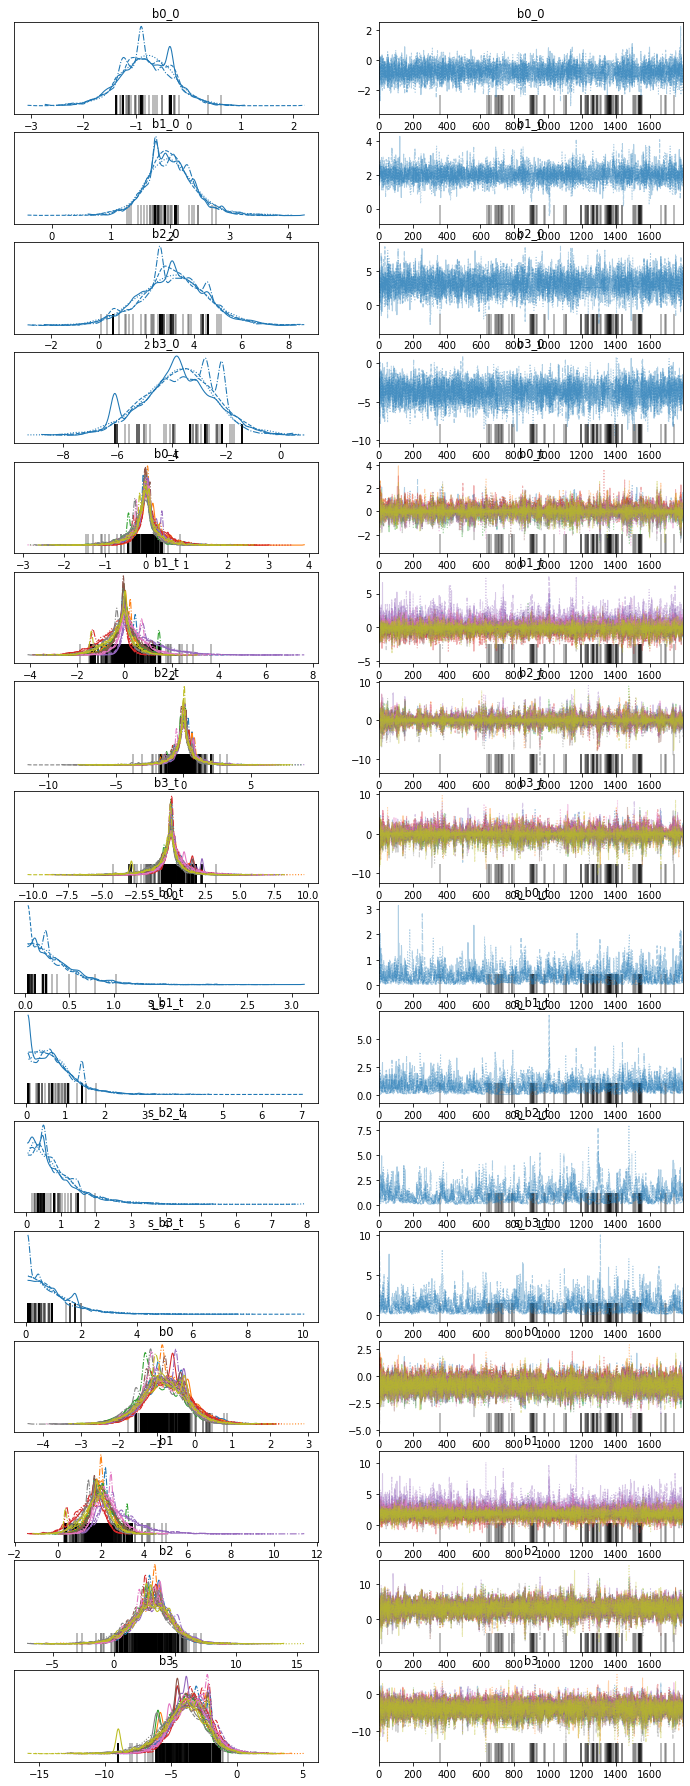

In [29]:
idata = az.from_pystan(fit)
az.plot_trace(idata)

# 前処理

In [39]:
result_df = az.summary(idata)
result_df.head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0_0,-0.793,0.505,-1.722,0.173,0.009,0.007,2850.0,4605.0,1.0
b1_0,2.001,0.429,1.248,2.889,0.008,0.006,3118.0,2705.0,1.0
b2_0,3.140,1.428,0.490,5.905,0.027,0.019,2810.0,1035.0,1.0
b3_0,-3.743,1.332,-6.218,-1.328,0.042,0.031,1015.0,435.0,1.0
b0_t[0],0.089,0.363,-0.558,0.877,0.006,0.007,4161.0,2391.0,1.0


In [43]:
# b1だけ取り出す.
print(result_df.index)

result_df['b1_t[0]':'b1_t[8]']

Index(['b0_0', 'b1_0', 'b2_0', 'b3_0', 'b0_t[0]', 'b0_t[1]', 'b0_t[2]',
       'b0_t[3]', 'b0_t[4]', 'b0_t[5]', 'b0_t[6]', 'b0_t[7]', 'b0_t[8]',
       'b1_t[0]', 'b1_t[1]', 'b1_t[2]', 'b1_t[3]', 'b1_t[4]', 'b1_t[5]',
       'b1_t[6]', 'b1_t[7]', 'b1_t[8]', 'b2_t[0]', 'b2_t[1]', 'b2_t[2]',
       'b2_t[3]', 'b2_t[4]', 'b2_t[5]', 'b2_t[6]', 'b2_t[7]', 'b2_t[8]',
       'b3_t[0]', 'b3_t[1]', 'b3_t[2]', 'b3_t[3]', 'b3_t[4]', 'b3_t[5]',
       'b3_t[6]', 'b3_t[7]', 'b3_t[8]', 's_b0_t', 's_b1_t', 's_b2_t', 's_b3_t',
       'b0[0]', 'b0[1]', 'b0[2]', 'b0[3]', 'b0[4]', 'b0[5]', 'b0[6]', 'b0[7]',
       'b0[8]', 'b1[0]', 'b1[1]', 'b1[2]', 'b1[3]', 'b1[4]', 'b1[5]', 'b1[6]',
       'b1[7]', 'b1[8]', 'b2[0]', 'b2[1]', 'b2[2]', 'b2[3]', 'b2[4]', 'b2[5]',
       'b2[6]', 'b2[7]', 'b2[8]', 'b3[0]', 'b3[1]', 'b3[2]', 'b3[3]', 'b3[4]',
       'b3[5]', 'b3[6]', 'b3[7]', 'b3[8]'],
      dtype='object')


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b1_t[0],-0.012,0.555,-1.144,1.031,0.010,0.009,3092.0,3161.0,1.00
b1_t[1],-0.020,0.532,-1.094,1.031,0.008,0.008,3825.0,3370.0,1.00
b1_t[2],0.066,0.558,-0.816,1.463,0.023,0.020,878.0,182.0,1.01
b1_t[3],-0.572,0.660,-1.867,0.461,0.025,0.018,715.0,2073.0,1.00
b1_t[4],0.860,0.954,-0.359,2.697,0.029,0.021,1029.0,2518.0,1.00
b1_t[5],0.082,0.540,-0.889,1.198,0.012,0.010,2367.0,516.0,1.01
b1_t[6],0.300,0.592,-0.689,1.583,0.012,0.011,2457.0,2682.0,1.00
b1_t[7],-0.334,0.602,-1.592,0.700,0.013,0.010,2469.0,3354.0,1.00
b1_t[8],-0.237,0.644,-1.472,0.972,0.025,0.018,775.0,227.0,1.01


In [44]:
unique_team_dict

{'木下マイスター東京': 1,
 '日本生命レッドエルフ': 2,
 'T.T彩たま': 3,
 '岡山リベッツ': 4,
 '木下アビエル神奈川': 5,
 '日本ペイントマレッツ': 6,
 '琉球アスティーダ': 7,
 'トップおとめピンポンズ名古屋': 8,
 '九州アスティーダ': 9}

# 回帰モデルによる因果効果の推定

In [3]:
df.columns

Index(['db', 's1', 's2', 's3', 'vm', 'HomeTeam_name', 'AwayTeam_name',
       'db_HomeWin', 's1_HomeWin', 's2_HomeWin', 's3_HomeWin', 'vm_HomeWin',
       'HomeTeam_win', 'HomeTeam_rate_AAA_and_S', 'AwayTeam_rate_AAA_and_S',
       'HomeTeam_rate_S', 'AwayTeam_rate_S', 'season_year'],
      dtype='object')

In [4]:
X_columns = ['db_HomeWin', 's1_HomeWin', 's2_HomeWin', 'HomeTeam_rate_S', 'AwayTeam_rate_S']

In [8]:
import numpy as np
import math
# シグモイド関数の定義
def sigmoid(x:float)->float:
    e = math.e
    s = 1 / (1 + e**(-x))
    return s

sigmoid(0.1)

0.52497918747894

In [13]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

result = smf.glm(formula="HomeTeam_win ~ db_HomeWin + HomeTeam_rate_S + AwayTeam_rate_S", data=df, family=sm.families.Binomial()).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           HomeTeam_win   No. Observations:                  265
Model:                            GLM   Df Residuals:                      261
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -148.11
Date:                Wed, 09 Mar 2022   Deviance:                       296.21
Time:                        13:09:52   Pearson chi2:                     265.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.9394      0.435     -2.160      0.031      -1.792      -0.087
db_HomeWin          1.9088      0.287      6.648      0.000       1.346       2.472
HomeTeam_rate_S     3.5559      1.054      3.374      0.001       1.490       5.621
AwayTeam_rate_S    -3.4833      1.060     -3.285      0.001      -5.561      -1.405
===================================================================================
"""

In [11]:
result = smf.glm(formula="HomeTeam_win ~ s1_HomeWin + HomeTeam_rate_S + AwayTeam_rate_S", data=df, family=sm.families.Binomial()).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           HomeTeam_win   No. Observations:                  265
Model:                            GLM   Df Residuals:                      261
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -151.13
Date:                Tue, 08 Mar 2022   Deviance:                       302.26
Time:                        23:05:35   Pearson chi2:                     268.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.9206      0.433     -2.127      0.033      -1.769      -0.072
s1_HomeWin          1.7802      0.281      6.342      0.000       1.230       2.330
HomeTeam_rate_S     2.7796      1.015      2.739      0.006       0.790       4.769
AwayTeam_rate_S    -2.6679      1.062     -2.513      0.012      -4.749      -0.587
===================================================================================
"""

In [12]:
result = smf.glm(formula="HomeTeam_win ~ s2_HomeWin + HomeTeam_rate_S + AwayTeam_rate_S", data=df, family=sm.families.Binomial()).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           HomeTeam_win   No. Observations:                  265
Model:                            GLM   Df Residuals:                      261
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -158.62
Date:                Tue, 08 Mar 2022   Deviance:                       317.23
Time:                        23:05:55   Pearson chi2:                     264.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.6240      0.410     -1.523      0.128      -1.427       0.179
s2_HomeWin          1.4209      0.272      5.222      0.000       0.888       1.954
HomeTeam_rate_S     2.8155      1.014      2.776      0.006       0.828       4.803
AwayTeam_rate_S    -2.9341      1.021     -2.873      0.004      -4.935      -0.933
===================================================================================
"""

In [13]:
result = smf.glm(formula="HomeTeam_win ~ s3_HomeWin + HomeTeam_rate_S + AwayTeam_rate_S", data=df, family=sm.families.Binomial()).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           HomeTeam_win   No. Observations:                  265
Model:                            GLM   Df Residuals:                      261
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -162.73
Date:                Tue, 08 Mar 2022   Deviance:                       325.46
Time:                        23:06:21   Pearson chi2:                     261.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.4921      0.406     -1.211      0.226      -1.289       0.304
s3_HomeWin          1.1983      0.272      4.399      0.000       0.664       1.732
HomeTeam_rate_S     3.5263      0.992      3.556      0.000       1.583       5.470
AwayTeam_rate_S    -4.0126      1.035     -3.878      0.000      -6.041      -1.984
===================================================================================
"""

In [14]:
result = smf.glm(formula="HomeTeam_win ~ vm_HomeWin + HomeTeam_rate_S + AwayTeam_rate_S", data=df, family=sm.families.Binomial()).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           HomeTeam_win   No. Observations:                  265
Model:                            GLM   Df Residuals:                      261
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -133.24
Date:                Wed, 09 Mar 2022   Deviance:                       266.49
Time:                        13:10:01   Pearson chi2:                     215.
No. Iterations:                    23                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.5162      0.417     -1.237      0.216      -1.334       0.302
vm_HomeWin         24.9658   1.72e+04      0.001      0.999   -3.37e+04    3.38e+04
HomeTeam_rate_S     3.4806      1.112      3.130      0.002       1.301       5.660
AwayTeam_rate_S    -3.3901      1.110     -3.054      0.002      -5.566      -1.214
===================================================================================
"""

In [14]:
result = smf.glm(formula="HomeTeam_win ~ db_HomeWin + s2_HomeWin + HomeTeam_rate_S + AwayTeam_rate_S", data=df, family=sm.families.Binomial()).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           HomeTeam_win   No. Observations:                  265
Model:                            GLM   Df Residuals:                      260
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -133.33
Date:                Tue, 08 Mar 2022   Deviance:                       266.66
Time:                        23:09:04   Pearson chi2:                     257.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.8182      0.506     -3.595      0.000      -2.810      -0.827
db_HomeWin          2.0725      0.317      6.547      0.000       1.452       2.693
s2_HomeWin          1.6239      0.314      5.166      0.000       1.008       2.240
HomeTeam_rate_S     3.1080      1.131      2.749      0.006       0.892       5.324
AwayTeam_rate_S    -2.9513      1.137     -2.596      0.009      -5.180      -0.723
===================================================================================
"""

In [15]:
result = smf.glm(formula="HomeTeam_win ~ db_HomeWin", data=df, family=sm.families.Binomial()).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           HomeTeam_win   No. Observations:                  265
Model:                            GLM   Df Residuals:                      263
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -157.76
Date:                Tue, 08 Mar 2022   Deviance:                       315.53
Time:                        23:12:46   Pearson chi2:                     265.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8650      0.188     -4.589      0.000      -1.234      -0.496
db_HomeWin     1.8635      0.273      6.822      0.000       1.328       2.399
==============================================================================
"""

In [16]:
result = smf.glm(formula="HomeTeam_win ~ s1_HomeWin", data=df, family=sm.families.Binomial()).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           HomeTeam_win   No. Observations:                  265
Model:                            GLM   Df Residuals:                      263
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -156.93
Date:                Tue, 08 Mar 2022   Deviance:                       313.85
Time:                        23:13:04   Pearson chi2:                     265.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9217      0.194     -4.742      0.000      -1.303      -0.541
s1_HomeWin     1.8957      0.274      6.922      0.000       1.359       2.433
==============================================================================
"""

In [17]:
result = smf.glm(formula="HomeTeam_win ~ db_HomeWin + s1_HomeWin", data=df, family=sm.families.Binomial()).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           HomeTeam_win   No. Observations:                  265
Model:                            GLM   Df Residuals:                      262
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -130.74
Date:                Tue, 08 Mar 2022   Deviance:                       261.49
Time:                        23:13:56   Pearson chi2:                     266.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1110      0.309     -6.833      0.000      -2.717      -1.505
db_HomeWin     2.1541      0.329      6.550      0.000       1.510       2.799
s1_HomeWin     2.1829      0.329      6.643      0.000       1.539       2.827
==============================================================================
"""